## Overview
Virtucon has deceided to enter into the air transportation business. The company is worried about the risk involved with aircraft operations and also, like the whole of this industry, it's environmental impact. Along the way we've asked the importanat questions of which aircraft is safest and which engine configuration has the least environmental impact. To give the company a competitive advantage we also searched for cities that are underserverd by the industry. 

Data was gathered from 4 distinct data sets to provide insights and answers to these questions. We've included the top 40 commercial aircraft operating between 2012 to 2022, the most recent years where data is avilable. Our recomendations for underseved cities are based on Census Bureau and Bureau of Transportation Statistics data.

Shown in the tables below is a summary of our findings for aircraft and engine combination and the underserved cities.

|Type  |   Narrow Body    |         Wide Body       |
|:------:| :--------------:   | :------------------------:|
| Used |   Airbus A319 / IAE V2500   | McDonell Douglas MD11 / Pratt & Whitney PW4000 |
| New  | Embraer ERJ-175 / General Electric CF34	 |      Boeing 767 / Pratt & Whitney PW4000      | 


| Underservered Metro Area |
| :----------------------: |
| Portland	ME             |
| New York	NY             |	
| Los Angeles CA           |	
| Miami	FL	               |

## Business Problem
Virtucon wants to enter the comercial aviation space. Before they do they want to understand the risks to operating in this space. Specifically they want ot understand aircraft saftey and impact on the enviornment. We've analyzed aircraft crash data, engine emissions data, and commercial flight data.

## Data
There are six sets of data used in this project, all coming form different sources.  The civil avaition accident data is from the National Trasportstion Safety Board. The domestic flight data is from the Buerau of Transportation Statistics. Data regarding Aircraft and Engines is from the Aircraft Safety Institute. Data on population comes form Wikipedia. Aircraft emmisions dat comes from th ICAO.


### Data Cleaning and Preparation
***

In [4]:
# Import the necessary modules

import pandas as pd
import numpy as np
import glob
import re
from bs4 import BeautifulSoup
import requests
import pickle
import matplotlib.pyplot as plt

In [5]:
# Load in T100 data from csv files. This data from Beureau of Transportation Statistics
# Give all US domestic flight data from 2012 to 2022 the most recent year for which data
# is available.

files_li = glob.glob('zippedData/T_T100D*.2.csv')
bts_df = pd.DataFrame(pd.read_csv(files_li[0]))
for i in range(1, len(files_li)):
    data = pd.read_csv(files_li[i])
    df1 = pd.DataFrame(data)
    bts_df = pd.concat([df1, bts_df], axis=0, ignore_index=True)

In [6]:
bts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4044332 entries, 0 to 4044331
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   DISTANCE             float64
 1   AIR_TIME             float64
 2   UNIQUE_CARRIER_NAME  object 
 3   ORIGIN               object 
 4   DEST                 object 
 5   AIRCRAFT_TYPE        int64  
 6   YEAR                 int64  
 7   MONTH                int64  
 8   DISTANCE_GROUP       int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 277.7+ MB


In [7]:
# Keep only top 40 used aircraft models. For practical purposes we won't consider low production aircraft.

bts_40 = bts_df['AIRCRAFT_TYPE'].value_counts().head(40).index.to_list()
indexNum = bts_df[~bts_df['AIRCRAFT_TYPE'].isin(bts_40)].index
bts_df.drop(indexNum, inplace=True)

In [8]:
# Get list of top 40 aircraft names for data cleaning

bts_des = pd.DataFrame(
    pd.unique(bts_df['AIRCRAFT_TYPE']), columns=['AIRCRAFT_TYPE'])

In [9]:
# BTS uses number code to identify aircraft type in it's flight data. The legend is in a seperate csv file.
# Load in the legend for aircraft type.

ac_df = pd.read_csv('zippedData/L_AIRCRAFT_TYPE.csv')

In [10]:
# Merge flight data with aircfaft type. This will match BTS type names to the fligt data.

bts_des = pd.merge(bts_des, ac_df, left_on='AIRCRAFT_TYPE', right_on='Code')

In [11]:
# Drop piston aircraft.

i = bts_des[(bts_des['Code'] == 40)].index
j = bts_des[(bts_des['Code'] == 35)].index
k = bts_des[(bts_des['Code'] == 194)].index
l = bts_des[(bts_des['Code'] == 79)].index
m = bts_des[(bts_des['Code'] == 479)].index
n = bts_des[(bts_des['Code'] == 415)].index
o = bts_des[(bts_des['Code'] == 416)].index
p = bts_des[(bts_des['Code'] == 412)].index
bts_des = bts_des.drop(i)
bts_des = bts_des.drop(j)
bts_des = bts_des.drop(k)
bts_des = bts_des.drop(l)
bts_des = bts_des.drop(m)
bts_des = bts_des.drop(n)
bts_des = bts_des.drop(o)
bts_des = bts_des.drop(p)

In [12]:
# These lists are used in name matching and to give standard names to aircraft.

common_words = ['BOEING', 'CHEROKEE', 'AIRBUS', 'INDUSTRIE', 'CANADAIR', 'EMBRAER', 'MCDONNELL', 'DOUGLAS',
                'DE', 'HAVILLAND', 'BEAVER', 'SUPER', 'NAVAJO', 'EM', 'ER', 'BEECH']

common_words_eng = ['ILYUSHIN', 'ANTONOV', 'JUNKERS', 'LOCKHEED', 'BOEING', 'AIRBUS', 'INDUSTRIE',
                    'CANADAIR', 'EMBRAER', 'STATIONAIR', 'MCDONNELL', 'DOUGLAS', 'DE', 'HAVILLAND', 'BEAVER',
                    'SUPER', 'NAVAJO', 'EM', 'ER', 'BEECH', 'CRAFT', 'BOMBARDIER', 'CANADA']

common_words_emi = ['TRENT', 'CFMI', 'PRATT & WHITNEY', 'GENERAL ELECTRIC', 'CANADA',
                    'ROLLSROYCE', 'LYCOMING', 'ALLISON', 'GARRETT', 'CONTINENTAL', 'IAE']

In [13]:
def short_name(name, x):
    if len(name) >= x:
        short_name = name[:x]
        return (short_name)
    return name

In [14]:
def remove_dash(name):
    name = name.replace('-', '')
    return name

In [15]:
def convert_upper(name):
    name = name.upper()
    return name

In [16]:
def convert_date(date):
    date = date.astype('datetime64[ns]')
    return date

In [17]:
def remove_slash(name):
    res = re.match(r"^[^/]*", name)
    return (str(res.group()))

In [18]:
def remove_common(name, common_w):
    for common in common_w:
        name = name.replace(common, '')
    return name

In [19]:
def remove_space(name):
    name = name.replace(' ', "")
    return name

In [20]:

def convert_boeing(name):
    if re.match(r"^(7)(.)(7)", name):
        name = name[:3]
    return name

In [21]:
def convert_crj(name):
    if re.match(r"^RJ", name):
        name = name.replace('RJ', 'CRJ')
    return name

In [22]:
# Change Descriptions for data cleaning and matching

bts_des.loc[bts_des['Code'] == 629, 'Description'] = 'Canadair RJ-200'
bts_des.loc[bts_des['Code'] == 631, 'Description'] = 'Canadair RJ-700'
bts_des.loc[bts_des['Code'] == 638, 'Description'] = 'Canadair RJ-900'
bts_des.loc[bts_des['Code'] == 838, 'Description'] = 'Boeing 737-800'
bts_des.loc[bts_des['Code'] == 674, 'Description'] = 'Embraer ERJ-130'
bts_des.loc[bts_des['Code'] == 676, 'Description'] = 'Embraer ERJ-140'
bts_des.loc[bts_des['Code'] == 675, 'Description'] = 'Embraer ERJ-145'
bts_des.loc[bts_des['Code'] == 677, 'Description'] = 'Embraer ERJ-170'
bts_des.loc[bts_des['Code'] == 678, 'Description'] = 'Embraer ERJ-190'

In [23]:
# Change Descriptions for data cleaning and matching

bts_des['Description'] = [convert_upper(x) for x in bts_des['Description']]
bts_des['Description'] = [remove_slash(x) for x in bts_des['Description']]
bts_des['Description'] = [remove_dash(x) for x in bts_des['Description']]
bts_des['Description'] = [remove_common(
    x, common_words) for x in bts_des['Description']]
bts_des['Description'] = [remove_space(x) for x in bts_des['Description']]
bts_des['Description'] = [short_name(x, 4) for x in bts_des['Description']]
bts_des['Description'] = [convert_boeing(x) for x in bts_des['Description']]
bts_des['Description'] = [convert_crj(x) for x in bts_des['Description']]

In [24]:
# Merge Flight data with cleaned aircraft names

bts_df = pd.merge(bts_df, bts_des[['Code', 'Description']],
                  left_on='AIRCRAFT_TYPE', right_on='Code')

In [25]:
# Drop Code column as we don't need it anymore
bts_des.drop(['AIRCRAFT_TYPE', 'Code'], axis=1, inplace=True)

### Crash Data

In [26]:
# Import Data Set from CSV

crash_df = pd.read_csv('zippedData/AviationData.csv', encoding='latin-1', dtype={6: str, 7: str,
                                                                                 14: str, 15: str,
                                                                                 28: str})

In [27]:
# This data contains information about aviation accidents. We will use if mainly for builing
# an aircraft safety score.

# There are 88889 rows but several columns have many less values.

crash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

In [28]:
# Drop rows before 2012 so we can match data by year in bts_df
date_mask = (crash_df['Event.Date'] > '2011-12-31')

# THIS RETURNS ALL ROWS GREATER THAN THE DATE PROVIDED ABOVE
crash_df = crash_df.loc[date_mask]

# Rows without an aircraft model type don't help use. Dropping these rows.
crash_df = crash_df.dropna(subset=['Model'])

In [29]:
# Convert Event.Date from string to datetime. Used to filter df on years

crash_df['Event.Date'] = crash_df['Event.Date'].astype('datetime64[ns]')

In [30]:
# Change Model name for data cleaning and matching

crash_df['Model'] = [convert_upper(x) for x in crash_df['Model']]
#crash_df['Event.Date'] = [convert_date(x) for x in crash_df['Event.Date']]
crash_df['Model'] = [remove_slash(x) for x in crash_df['Model']]
crash_df['Model'] = [remove_dash(x) for x in crash_df['Model']]
crash_df['Model'] = [remove_common(x, common_words) for x in crash_df['Model']]
crash_df['Model'] = [remove_space(x) for x in crash_df['Model']]
crash_df['Model'] = [short_name(x, 4) for x in crash_df['Model']]
crash_df['Model'] = [convert_boeing(x) for x in crash_df['Model']]
#crash_df['Model'].replace('PA-', 'PA', inplace=True, regex=True)

In [31]:
# Takes in an aircraft model name and returns the cloest match in bts_des

def match_types(model):
    for newmodel in bts_des['Description']:
        if newmodel.startswith(model):
            #print(f'Processing: {model} \t:{newmodel}')
            return newmodel

In [32]:
# Create new column that matches model name form bts_des

crash_df['NewModel'] = [match_types(model) for model in crash_df['Model']]

In [33]:
# Drop Report.Status column as we don't need it and it conflicts with excel writer
crash_df.drop(['Report.Status'], axis=1, inplace=True)

In [34]:
crash_lite_df = crash_df.dropna(subset=['NewModel']).copy()


### Engine Data

In [35]:
# In place of running this and making lots of web requests, import the pickle file from below
# Assign URL
# url = "https://asn.flightsafety.org/database/engines/"

# Make a GET request to fetch the raw HTML content
# html_content = requests.get(url).text

# Parse the response with html.parser
# soup = BeautifulSoup(html_content,"html.parser")

# The data we need are wrapped in <a> tags. Grab all the <a> tags here and we'll filter later.
# datas = soup.find_all("a")


# Make list of URLs and list oF Aircraft to create dictionary
# k = []
# v = []
# for item in datas:
#     if 'engine' in item['href']:
#         k.append(item['href'])
#         v.append(item.text)

# lookup_dict = {'URL': k, 'Engine': v}


# url_df = pd.DataFrame.from_dict(lookup_dict)

# with open('lookup_dict.pkl', 'wb') as f:
#     pickle.dump(lookup_dict, f)

with open('zippedData/lookup_dict.pkl', 'rb') as f:
    lookup_dict = pickle.load(f)

In [36]:
# Take in the engine and retrieve the matching data page with Aircraft data
# Add Aircraft list from web python list.
# Return the python list

# url_p1 = 'https://asn.flightsafety.org'
# def lookup_ac(url_p2):
#     return_list = []
#     url = f'{url_p1}{url_p2}'
#     sub_content = requests.get(url).text
#     soup2 = BeautifulSoup(sub_content,"html.parser")
#     u_list=soup2.find_all('ul')[1]
#     i = 0
#     while i < len(u_list.select('li')):
#         (u_list.select('li')[i].text)
#         return_list.append(u_list.select('li')[i].text)
#         i += 1
#     return(return_list)

# Create Aircraft column to list aircraft for each engine.
# url_df['Aircraft'] = url_df['URL'].map(lookup_ac)

# Save df to pickle file.
# url_df.to_pickle('zippedData/url_df.pkl')

with open('zippedData/url_df.pkl', 'rb') as f:
    url_df = pickle.load(f)

In [37]:
# Create a row for each aircraft for each engine.
# Iterate through url_df['Aircraft'] column. For each element
# in list, create a new row.

engines = []
aircraft = []
for idx, row in url_df.iterrows():
    for ac in row['Aircraft']:
        engines.append(row['Engine'])
        aircraft.append(ac)

In [38]:
# Create dictionary from lists to load into dataFrame

ac_eng_dict = {'Engine': engines, 'Aircraft': aircraft}

In [39]:
# Create dataFrame from dictionary

engines_df = pd.DataFrame.from_dict(ac_eng_dict)

In [40]:
# We use this data to match the airplane with it's engine so we can ultimatley get the
# engine's emissions

engines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Engine    466 non-null    object
 1   Aircraft  466 non-null    object
dtypes: object(2)
memory usage: 7.4+ KB


In [41]:
# Change Name for data cleaning and matching

engines_df.loc[engines_df['Aircraft'] == 'Bombardier CRJ100 / 200 / 440'] = ['General Electric CF34','Canadair RJ-100']
engines_df.loc[engines_df['Aircraft'] == 'Bombardier CRJ700'] = ['General Electric CF34','Canadair RJ-700']
engines_df.loc[engines_df['Aircraft'] == 'Bombardier CRJ900'] = ['General Electric CF34','Canadair RJ-900']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Canadair RJ-200']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Canadair RJ-440']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-130']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-135']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-140']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-175']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-190']
engines_df.loc[len(engines_df.index)] = ['Pratt & Whitney JT8D', 'McDonnell Douglas DC-9-80']

In [42]:
# Change Aircraft name for data cleaning and matching

engines_df['Aircraft'] = [convert_upper(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_slash(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_dash(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_common(x, common_words_eng) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_space(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [short_name(x, 4) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [convert_boeing(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [convert_crj(x) for x in engines_df['Aircraft']]

In [43]:
# Change Engine name for data cleaning and matching

engines_df['Engine_Name'] = [convert_upper(x) for x in engines_df['Engine']]
engines_df['Engine_Name'] = [remove_slash(x) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_dash(x) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_common(x, common_words_emi) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_common(x, common_words_emi) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_space(x) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [short_name(x, 5) for x in engines_df['Engine_Name']]
#engines_df['Engine_Name'] = [convert_boeing(x) for x in engines_df['Engine_Name']]
#engines_df['Engine_Name'] = [convert_crj(x) for x in engines_df['Engine_Name']]

In [44]:
# Add Engine data to bts_des

bts_des = pd.merge(bts_des, engines_df,left_on='Description', right_on='Aircraft', how='left')
bts_des.drop_duplicates(inplace=True)

### Emissions Data

In [45]:
# Load Engine emissions data

emissions_df = pd.read_excel('zippedData/edb-emissions-databank_v30__web_.xlsx',
                             sheet_name='Gaseous Emissions and Smoke', 
                             usecols=('A:D, AJ'))

In [46]:
emissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UID No                 834 non-null    object 
 1   GSDB No                834 non-null    int64  
 2   Manufacturer           834 non-null    object 
 3   Engine Identification  834 non-null    object 
 4   CO Dp/Foo Avg (g/kN)   834 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 32.7+ KB


In [47]:
# Change Engine name for data cleaning and matching

emissions_df['Engine Identification'] = [convert_upper(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_slash(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_dash(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_common(x, common_words_emi) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_space(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [short_name(x, 5) for x in emissions_df['Engine Identification']]

In [48]:
# Force name change for certain engines

emissions_df.at[527,'Engine Identification'] = 'PW100'
emissions_df.at[611,'Engine Identification'] = 'PW200'
emissions_df.at[633,'Engine Identification'] = 'PW400'

In [49]:
# Takes in an Engine name and returns the CO2 value

def match_engine(str1):
    tmp_df = pd.DataFrame()
    mask = tmp_df['engine_id_starts_with_CFM'] = list( 
        map(lambda x: x.startswith(str1), emissions_df['Engine Identification'])) 
    filtered_df = emissions_df[mask]
    #return(filtered_df.at[0,1]['CO Dp/Foo Avg (g/kN)']).head(1)
    if filtered_df.shape[0] < 1:
        return 0
    return(filtered_df.iat[0,4])

In [50]:
# Add Co2 data to bts_des

bts_des['Co2'] = [match_engine(x) for x in bts_des['Engine_Name']]

## Methods
Using data from 5 different datasets presents the problem of name matching. The first step in processing the data was to assign standard names for each aircraft and engine across the datasets. This was done by using a combination of string manipulation and regular expressions. We filtered the BTS aircraft list to the 40 most popular aircraft, not including propeller based aircraft, as they are less suitible to commercial operations. To determine the saftey of an aircraft we created a Injury Score based on the BTS rating. From the BTS website: “Rates are computed by dividing the number of Fatalities, Seriously injured persons, Total accidents, and Fatal accidents by the number of Aircraft-miles, Aircraft departures, or Flight hours." Our formula is 3 points for fatality; 1 point for serious injury and .5 points for minor injury all divided by the number of departures.To determine the enviornmental impact of an aircraft we merged the aircraft list from BTS with engine data from the Aircraft Safety Institute, and then with emissions data from the ICAO. The Injuty Score and Emissions metrics were then normalized so they can be presented with even weights.

To show which cities were underserverd by airlines we combined flight data from BTS, List of US Airports from Kaggle, and population data from Wikipedia. The List of US airports were loaded into a pandas dataframe and grouped by City and State. Next this grouping of airports was used to sum the total number of flights departing from that city. The Flight to Person ratio was calculated by diving the number of flights per city by it's population. 


### Data Processing

In [51]:
# Some rows have NaN for values. Replace these with 0 value. 

crash_df['Total.Fatal.Injuries'] = crash_df['Total.Fatal.Injuries'].fillna(0)
crash_df['Total.Serious.Injuries'] = crash_df['Total.Serious.Injuries'].fillna(0)
crash_df['Total.Minor.Injuries'] = crash_df['Total.Minor.Injuries'].fillna(0)

In [52]:
# Our scoring system will use 3 points for fatality; 1 point for serious injury and .5 points for minor injury.

crash_df['Injury_Score'] = crash_df['Total.Fatal.Injuries'].map(lambda x: x*3)
crash_df['Injury_Score'] = crash_df['Injury_Score'] + crash_df['Total.Serious.Injuries']
crash_df['Injury_Score'] = crash_df['Injury_Score'] + (crash_df['Total.Minor.Injuries'] * .5)

In [53]:
# Sum Injury Score and put into new temp df

total_score = crash_df.groupby('NewModel')['Injury_Score'].sum().to_frame()

total_score['Count'] = bts_df.groupby('Description').size()

total_score['Rating'] = (total_score['Injury_Score'] / total_score['Count'])

total_score = pd.merge(total_score, bts_des[['Co2', 'Aircraft', 'Engine']], left_on='NewModel', 
                       right_on='Aircraft', how='left')

In [54]:

final_score = total_score.sort_values(
    ['Co2', 'Rating'], ascending=[True, True])

# Drop engines for which data is unavailable
final_score = final_score.loc[final_score['Co2'] > 0]

In [55]:
# Normalize Injury Rating and Co2
co2_max = final_score['Co2'].max()
co2_min = final_score['Co2'].min()
rating_max = final_score['Rating'].max()
rating_min = final_score['Rating'].min()
co2_range = co2_max - co2_min
rating_range = rating_max - rating_min

# normalized_value = (feature_value - feature_min) / (feature_max - feature_min)

final_score['Co2 Normal'] = [((x - co2_min) / (co2_range) * 100)
                             for x in final_score['Co2']]

final_score['Rating Normal'] = [
    ((x - rating_min) / (rating_range) * 100) for x in final_score['Rating']]

final_score['Combined'] = final_score['Co2 Normal'] + \
    final_score['Rating Normal']

final_sorted = final_score.sort_values(by=['Combined'])

### Airport Data Analysis


In [57]:
# Load Airport data from csv file
# We use ICACO data to provide aitports code to cities. We'll use this to match
# flight data from bts_df

ap_df = pd.read_csv('zippedData/us-airports.csv')

In [58]:
# Get Population data from Wikipedia

url = "https://en.wikipedia.org/wiki/List_of_North_American_metropolitan_areas_by_population"

wiki_df = pd.read_html(url)[0]

wiki_df = wiki_df[(wiki_df['Country'] == 'United States')]

In [59]:
# Only keep columns we need. Drop other columns

ap_df = ap_df[['id', 'ident', 'type', 'name', 'local_region', 'municipality', 'local_code',
               'iata_code', 'keywords']]

ap_df = ap_df[(ap_df['type'] == 'large_airport')]

In [60]:
# Get count of flights originated at airport and convert to dict

ap_counts = bts_df['ORIGIN'].value_counts()
ap_counts_dict = ap_counts.to_dict()

In [61]:
# This takes in an airport code and returns the total number of flights orginating from there

def get_num_flt(code):
    try:
        val = ap_counts_dict[code]
    except:
        val = 0

    return val

In [62]:
# Takes in city name and returns population

def get_wiki_pop(city):
    try:
        pop = wiki_df.loc[wiki_df['Metropolitan area']
                          == city, 'Population'].values[0]
        return pop
    except:
        return 0

In [63]:
# Create df to combine flight data and population
apuse_df = ap_df.copy()
apuse_df['NumFlights'] = [get_num_flt(x) for x in apuse_df['iata_code']]

ap_mask = (apuse_df['NumFlights'] != 0)
apuse_df = apuse_df.loc[ap_mask]

In [64]:
# Group city and state airports and sum total flights from multiple airports

result2 = apuse_df.groupby(['municipality', 'local_region'])

# extract keys from groups

keys = result2.groups.keys()

# Add num of flights to city name

city_lst = []
state_lst = []
num_flt_lst = []
iata_lst = []

for i in keys:
    a_group = result2.get_group(i)
    city_lst.append(a_group['municipality'][:1].to_string(index=False))
    state_lst.append(a_group['local_region'][:1].to_string(index=False))
    num_flt_lst.append(a_group['NumFlights'].sum())
    iata_lst.append(a_group['iata_code'][:1].to_string(index=False))

In [65]:
# Add population data to result_df

result2_dict = {'City': city_lst, 'State': state_lst,
                'NumFlights': num_flt_lst, 'Code': iata_lst}
result2_df = pd.DataFrame.from_dict(result2_dict)

pop_lst = []
for i, x in result2_df.iterrows():
    pop_lst.append(get_wiki_pop(x['City']))

result2_df['Population'] = pop_lst

result2_df = result2_df.loc[result2_df['Population'] > 0]

In [66]:
# Calculate flight per popuation ratio

pfr_lst = []
for i, x in result2_df.iterrows():

    ratio = x['Population']/x['NumFlights']
    pfr_lst.append(ratio)

result2_df['FPR'] = pfr_lst

## Results
The result show the safest aircraft is the Embreaer ERJ-145 and the Bombardier CRJ-700. These were closely followed by the Boeing 717. The combination of safest and least emissions were the (used) Airbus A319, McDonell Douglass MD11, and  (new) ERJ-175 and Boeing 767.


In [67]:
result2_df = result2_df.sort_values('FPR', ascending=False)[:11]

In [68]:
result2_df[['City', 'State', 'FPR']]

,City,State,FPR
46,Portland,ME,415.729577
35,New York,NY,259.439290
27,Los Angeles,CA,200.556894
30,Miami,FL,171.359531
51,Sacramento,CA,160.136403
53,San Antonio,TX,127.566186
5,Boston,MA,127.011528
12,Columbus,OH,115.058592
43,Philadelphia,PA,114.615198
21,Houston,TX,106.999753


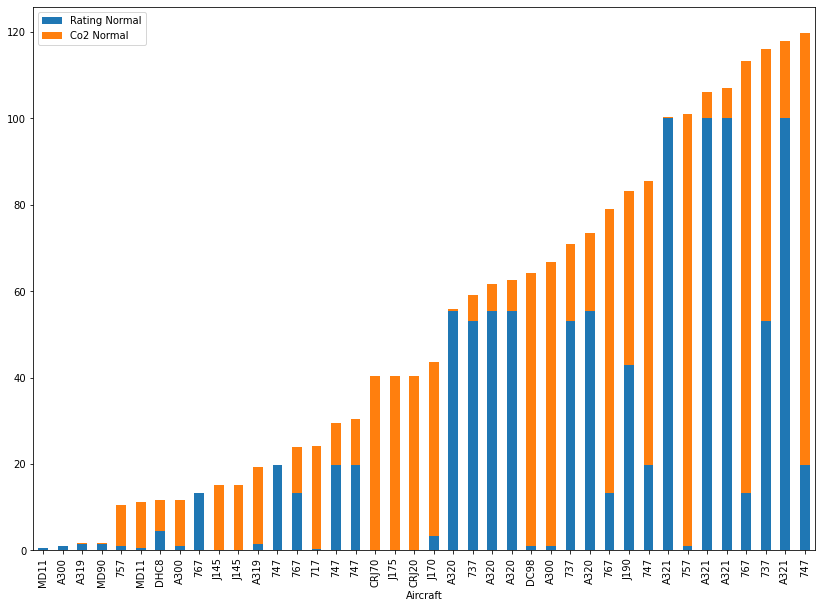

In [69]:
plt.rcParams['figure.figsize'] = [14, 10]
final_sorted.plot(x='Aircraft', y=['Rating Normal', 'Co2 Normal'], kind='bar', stacked=True)

plt.show()


In [70]:
# Group origin and destination pairs for Sankey diagram
od_grp = bts_df.groupby(['ORIGIN', 'DEST']).size().sort_values(ascending=False)
od_grp_df = od_grp.reset_index(name='count')

# Limit origin to top 11 FPR airports
od_grp_df = od_grp_df[od_grp_df['ORIGIN'].isin(result2_df['Code'][:11])]

# Delete entries with less than 1000 trips
od_grp_df.drop(od_grp_df[od_grp_df['count'] < 1000].index, inplace=True)

In [71]:
# Write result2_df to excel for use in Tableau

writer = pd.ExcelWriter('zippedData/tableau.xlsx')
final_sorted.to_excel(writer, 'Sheet1')
result2_df.to_excel(writer, 'Sheet2')
crash_lite_df.to_excel(writer, 'Sheet3')
od_grp_df.to_excel(writer, 'Sheet4')
writer.close()